In [1]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

In [2]:
PATH = '/Users/jisungyoon/Dropbox/SME-dropbox/Data/Derived/Descriptive/org/organization_flows.csv'
flow_data = pd.read_csv(PATH)

In [3]:
INPUT_EMBEDDING_FILE = '/Users/jisungyoon/Dropbox/SME-dropbox/Data/Derived/Embeddings/precedence/word2vec_d300_ws1_model.bin'
model = Word2Vec.load(INPUT_EMBEDDING_FILE)
vocab_list = set(list(model.wv.vocab.keys()))
embedding_dict = {k: model.wv[k] for k in vocab_list}
vocab_list_ = model.wv.index2word
out_emb = {word: model.syn1neg[index] for index, word in enumerate(vocab_list_)}

/Users/jisungyoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn1neg` (Attribute will be removed in 4.0.0, use self.trainables.syn1neg instead).
  


# 1. check In_out_si

In [4]:
from numpy.linalg import norm
in_si = [np.exp(np.power(norm(embedding_dict[vocab]), 2)/2) for vocab in vocab_list]
out_si = [np.exp(np.power(norm(out_emb[vocab]), 2)/2) for vocab in vocab_list]

Text(0, 0.5, '$s_i^{out}$')

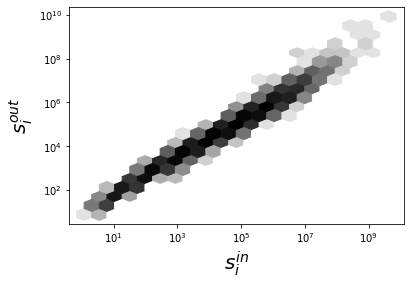

In [7]:
import matplotlib.pyplot as plt
plt.hexbin(in_si, out_si, bins='log', yscale='log', xscale='log', cmap='gray_r', mincnt=0, gridsize=20)
plt.xlabel(r'$s_i^{in}$', fontsize=20)
plt.ylabel(r'$s_i^{out}$', fontsize=20)

# 2. Calculate Potential

In [9]:
def calculate_distance_function(x_i, x_j):
    l2_distance = np.linalg.norm(x_i - x_j)
    distance_part = np.power(l2_distance, 2) / 2
    return 1/np.exp(distance_part)

In [10]:
matrix_for_potential = np.zeros((len(vocab_list), len(vocab_list)))
from tqdm import tqdm
for i, word_1 in tqdm(enumerate(vocab_list)):
    for j, word_2 in enumerate(vocab_list):
        matrix_for_potential[i][j] = in_si[j] * calculate_distance_function(embedding_dict[word_1], embedding_dict[word_2])

7090it [09:51, 11.98it/s]


In [22]:
potential_with_self = matrix_for_potential.sum(axis=1)

In [24]:
potential_without_self = []
for i, vocab in enumerate(vocab_list):
    dummy = 0
    for j, vocab_ in enumerate(vocab_list):
        if i != j:
            dummy += matrix_for_potential[i][j]
    potential_without_self.append(dummy)

# 3. Calculate Partiotion functions part

In [32]:
dot_product_matrix = np.zeros((len(vocab_list), len(vocab_list)))
for i, word_1 in tqdm(enumerate(vocab_list)):
    for j, word_2 in enumerate(vocab_list):
        dot_product_matrix[i][j] = np.dot(embedding_dict[word_1], embedding_dict[word_2])
parition_function_array = dot_product_matrix.sum(axis=1)

7090it [01:21, 86.78it/s]


# 4. Obtain size info

In [36]:
INPUT_SIZE_FILE = '/Users/jisungyoon/Dropbox/SME-dropbox/Data/raw/2008-2019_inst_sizes.txt'
size_data = pd.read_csv(INPUT_SIZE_FILE, sep="\t", dtype={"cwts_org_no": str})
size_data = size_data.drop(size_data.index[len(size_data) - 1])
size_data.person_count = size_data.person_count.astype(int)
mean_size_dict = (
    size_data.groupby("cwts_org_no")["person_count"].apply(np.mean).to_dict()
)
size_list = np.array([mean_size_dict[inst] for inst in vocab_list])

# 5. Compare

([<matplotlib.axis.YTick at 0x1a1d5241d0>,
 <a list of 4 Text yticklabel objects>)

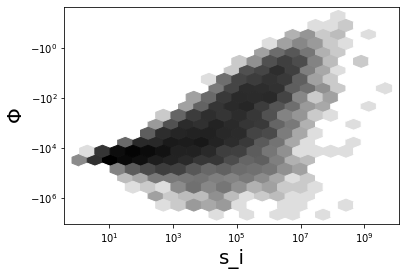

In [33]:
plt.hexbin(in_si, potential_without_self , bins='log', yscale='log', xscale='log', cmap='gray_r', mincnt=0, gridsize=20)
plt.xlabel(r's_i', fontsize=20)
plt.ylabel(r'$\Phi$', fontsize=20)
plt.gca().invert_yaxis()
plt.yticks([1, 100, 10000, 1000000], [r'$-10^0$',r'$-10^2$',r'$-10^4$', r'$-10^6$'])

Text(0.5, 0, '$s_i$')

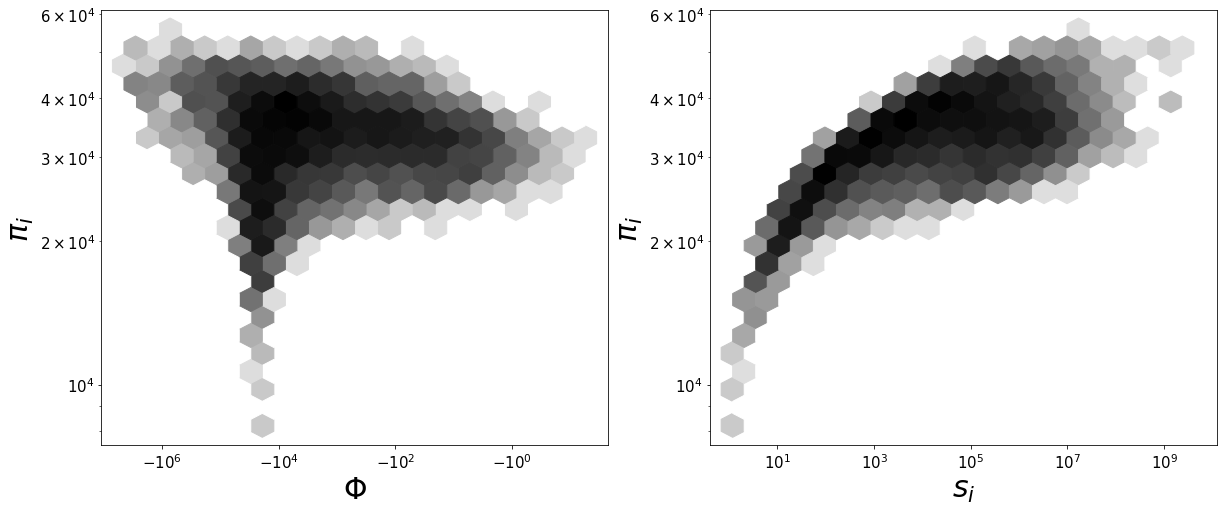

In [37]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
ax1.hexbin(potential_without_self,parition_function_array, bins='log', yscale='log', xscale='log', cmap='gray_r', mincnt=0, gridsize=20)
ax1.set_ylabel(r'$\pi_i$', fontsize=30)
ax1.set_xlabel(r'$\Phi$', fontsize=30)
ax1.invert_xaxis()
ax1.set_xticks([1, 100, 10000, 1000000])
ax1.set_xticklabels([r'$-10^0$',r'$-10^2$',r'$-10^4$', r'$-10^6$'])
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 15)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 15)

ax2.hexbin(in_si, parition_function_array, bins='log', yscale='log', xscale='log', cmap='gray_r', mincnt=0, gridsize=20)
ax2.set_ylabel(r'$\pi_i$', fontsize=30)
ax2.set_xlabel(r'$s_i$', fontsize=30)

Text(0.5, 0, '$s_i$')

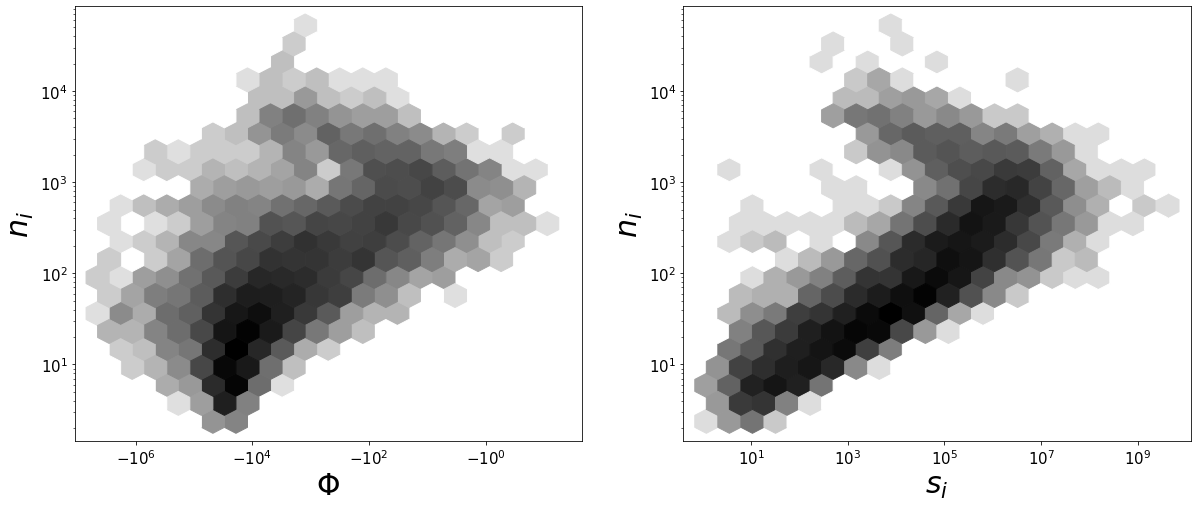

In [40]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
ax1.hexbin(potential_without_self,size_list, bins='log', yscale='log', xscale='log', cmap='gray_r', mincnt=0, gridsize=20)
ax1.set_ylabel(r'$n_i$', fontsize=30)
ax1.set_xlabel(r'$\Phi$', fontsize=30)
ax1.invert_xaxis()
ax1.set_xticks([1, 100, 10000, 1000000])
ax1.set_xticklabels([r'$-10^0$',r'$-10^2$',r'$-10^4$', r'$-10^6$'])
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 15)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 15)

ax2.hexbin(in_si,size_list, bins='log', yscale='log', xscale='log', cmap='gray_r', mincnt=0, gridsize=20)
ax2.set_ylabel(r'$n_i$', fontsize=30)
ax2.set_xlabel(r'$s_i$', fontsize=30)

In [41]:
INPUT_META_INFO_FILE =  '/Users/jisungyoon/Dropbox/SME-dropbox/Data/Additional/institution_lookup_with_states.txt'
meta_info = pd.read_csv(INPUT_META_INFO_FILE, sep="\t")
meta_info = meta_info.set_index('cwts_org_no')
code_to_full_name = meta_info['full_name'].to_dict()
code_to_city = meta_info['city'].to_dict()
code_to_country = meta_info['country_iso_name'].to_dict()
code_to_country_iso = meta_info['country_iso_alpha'].to_dict()
code_to_org_type = meta_info['org_type'].to_dict()
code_to_region = meta_info['region'].to_dict()

In [42]:
institute_list = vocab_list

In [43]:
full_name_list = np.array([code_to_full_name[int(inst)] for inst in institute_list])
country_list = np.array([code_to_country[int(inst)] for inst in institute_list])
region_list = np.array([code_to_region[int(inst)] for inst in institute_list])
city_list = np.array([code_to_city[int(inst)] for inst in institute_list])
org_type_list = np.array([code_to_org_type[int(inst)] for inst in institute_list])
size_list = np.array([mean_size_dict[inst] for inst in institute_list])

In [45]:
df = pd.DataFrame({
    'negative_gravity_potential': potential_without_self,
    's_i': in_si,
    'name': full_name_list,
    'org_type': org_type_list,
    'size': size_list,
    'city': city_list,
    'country': country_list,
})


In [46]:
import plotly.graph_objects as go
import plotly as py
import plotly.express as px
def draw_figure(df, country='all', color_type_list = ['country']):
    for color_type in color_type_list:
        fig = px.scatter(df, x="s_i", y="negative_gravity_potential", color=color_type,
                         hover_name="name", hover_data=["org_type", 'size', 'country', 'city'])
        fig.update_layout(
            autosize=False,
            width=1800,
            height=1500,
        )
        fig.update_traces(marker=dict(size=4),
                          selector=dict(mode='markers'))
        fig.update_layout(xaxis_type="log", yaxis_type="log")

        py.offline.plot(fig, filename="{}_{}_new.html".format(country, color_type),  auto_open=False)

In [47]:
draw_figure(df)